In [1]:
!pip install h2o
%matplotlib inline
import random, os, sys
import h2o
import pandas
import pprint
import operator
import matplotlib
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from tabulate import tabulate
from h2o.automl import H2OAutoML
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np

In [2]:
# Task 1: Connect to a cluster
h2o.init(strict_version_check=False)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,20 mins 25 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.2
H2O_cluster_version_age:,15 days
H2O_cluster_name:,H2O_from_python_HP_m3n7sy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.922 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [3]:
# set this to True if interactive (matplotlib) plots are desired
interactive = True
if not interactive: matplotlib.use('Agg', warn=False)
import matplotlib.pyplot as plt

In [5]:
# Task 2: Load data - 1 row per flight.  Has columns showing the origin,
# destination, departure and arrival time, carrier information, and
# whether the flight was delayed.
data = h2o.import_file( 'https://raw.githubusercontent.com/h2oai/h2o-tutorials/master/tutorials/data/allyears2k.csv' )


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [6]:


data.describe()

Rows:43978
Cols:31

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,IsArrDelayed,IsDepDelayed
type,int,int,int,int,int,int,int,int,enum,int,enum,int,int,int,int,int,enum,enum,int,int,int,int,enum,int,int,int,int,int,int,enum,enum
mins,1987.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,,1.0,,16.0,17.0,14.0,-63.0,-16.0,,,11.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,,
mean,1997.5,1.409090909090909,14.601073263904679,3.820614852880986,1345.846661382076,1313.2228614307153,1504.6341303788893,1485.2891673109282,,818.8429896766569,,124.81452913540424,125.02156260661886,114.31611109078271,9.317111936984311,10.007390655600112,,,730.1821905650503,5.381368059530625,14.168634184732056,0.024694165264450407,,0.0024785119832643593,4.047800291055636,0.28937646927124144,4.8550319041755285,0.017015560282100085,7.620060450016791,,
maxs,2008.0,10.0,31.0,7.0,2400.0,2359.0,2400.0,2359.0,,3949.0,,475.0,437.0,402.0,475.0,473.0,,,3365.0,128.0,254.0,1.0,,1.0,369.0,201.0,323.0,14.0,373.0,,
sigma,6.3443609017105995,1.8747113713439623,9.17579042586145,1.9050131191328963,465.3408991242339,476.25113999259975,484.347487903516,492.750434122701,,777.404369163635,,73.97444166059017,73.40159463000926,69.63632951506108,29.840221962414837,26.438809042916446,,,578.4380082304243,4.201979939864827,9.905085747204323,0.15519314135784237,,0.049723487218862286,16.205729904484198,4.416779898734125,18.619776221475675,0.40394018210151184,23.48756587410621,,
zeros,0,0,0,0,0,569,0,569,,0,,0,0,0,1514,6393,,,0,623,557,42892,,43869,7344,8840,7388,8914,7140,,
missing,0,0,0,0,1086,0,1195,0,0,0,32,1195,13,16649,1195,1086,0,0,35,16026,16024,0,9774,0,35045,35045,35045,35045,35045,0,0
0,1987.0,10.0,14.0,3.0,741.0,730.0,912.0,849.0,PS,1451.0,NA,91.0,79.0,nan,23.0,11.0,SAN,SFO,447.0,nan,nan,0.0,NA,0.0,nan,nan,nan,nan,nan,YES,YES
1,1987.0,10.0,15.0,4.0,729.0,730.0,903.0,849.0,PS,1451.0,NA,94.0,79.0,nan,14.0,-1.0,SAN,SFO,447.0,nan,nan,0.0,NA,0.0,nan,nan,nan,nan,nan,YES,NO
2,1987.0,10.0,17.0,6.0,741.0,730.0,918.0,849.0,PS,1451.0,NA,97.0,79.0,nan,29.0,11.0,SAN,SFO,447.0,nan,nan,0.0,NA,0.0,nan,nan,nan,nan,nan,YES,YES


In [7]:
# ----------

# 2- Data exploration and munging. Generate scatter plots 
# of various columns and plot fitted GLM model.

# Function to fit a GLM model and plot the fitted (x,y) values
def scatter_plot(data, x, y, max_points = 1000, fit = True):
    if(fit):
        lr = H2OGeneralizedLinearEstimator(family = "gaussian")
        lr.train(x=x, y=y, training_frame=data)
        coeff = lr.coef()
    df = data[[x,y]]
    runif = df[y].runif()
    df_subset = df[runif < float(max_points)/data.nrow]
    df_py = h2o.as_list(df_subset)
    
    if(fit): h2o.remove(lr._id)

    # If x variable is string, generate box-and-whisker plot
    if(df_py[x].dtype == "object"):
        if interactive: df_py.boxplot(column = y, by = x)
    # Otherwise, generate a scatter plot
    else:
        if interactive: df_py.plot(x = x, y = y, kind = "scatter")
    
    if(fit):
        x_min = min(df_py[x])
        x_max = max(df_py[x])
        y_min = coeff["Intercept"] + coeff[x]*x_min
        y_max = coeff["Intercept"] + coeff[x]*x_max
        plt.plot([x_min, x_max], [y_min, y_max], "k-")
    if interactive: plt.show()


glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


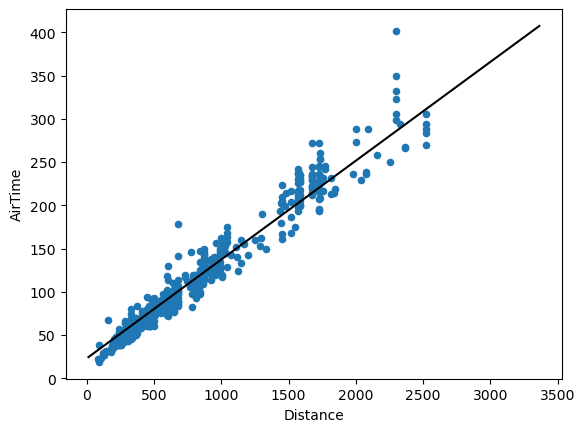

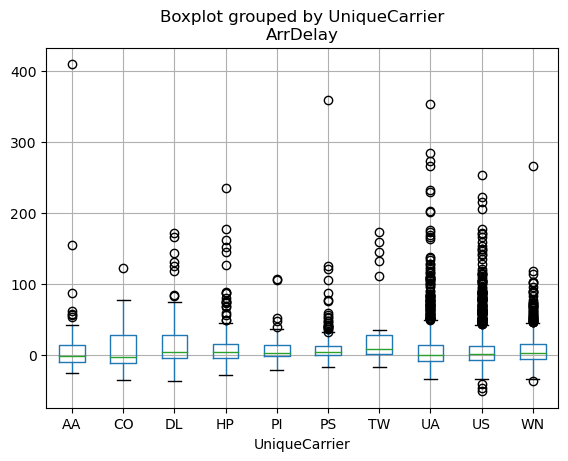

In [8]:
# Task 3: Generate scatterplots for "Distance" and "Airtime" and one for "Unique Carrier" and the "ArrDelay" 
scatter_plot(data, "Distance", "AirTime", fit = True)
scatter_plot(data, "UniqueCarrier", "ArrDelay", max_points = 5000, fit = False)

In [9]:
# Task 4: Use the .group_by function to group flights by month 
grouped = data.group_by("Month")
bpd = grouped.count().sum("Cancelled").frame
bpd.show()
bpd.describe()
bpd.dim


Month,nrow,sum_Cancelled
1,41979,1067
10,1999,19


Rows:2
Cols:3

,Month,nrow,sum_Cancelled
type,int,int,int
mins,1.0,1999.0,19.0
mean,5.5,21989.0,543.0
maxs,10.0,41979.0,1067.0
sigma,6.363961030678928,28270.12911183817,741.0479066835018
zeros,0,0,0
missing,0,0,0
0,1.0,41979.0,1067.0
1,10.0,1999.0,19.0


[2, 3]

In [10]:
# Task 5: Convert the "Year," "Month," "DayOfWeek," "Cancelled" columns to factors
data["Year"]      = data["Year"]     .asfactor()
data["Month"]     = data["Month"]    .asfactor()
data["DayOfWeek"] = data["DayOfWeek"].asfactor()
data["Cancelled"] = data["Cancelled"].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


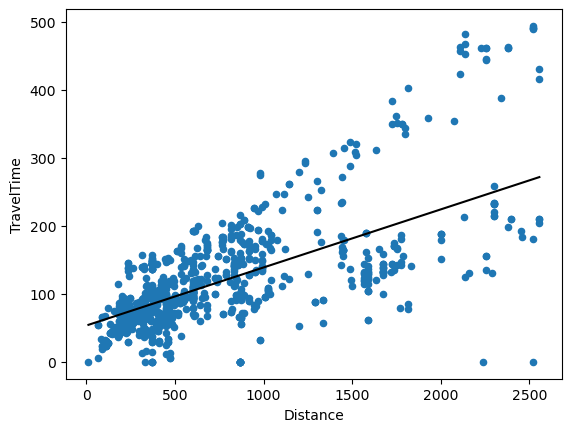

In [11]:
# Calculate and plot travel time
hour1 = data["CRSArrTime"] / 100
mins1 = data["CRSArrTime"] % 100
arrTime = hour1*60 + mins1

hour2 = data["CRSDepTime"] / 100
mins2 = data["CRSDepTime"] % 100
depTime = hour2*60 + mins2


data["TravelTime"] = (arrTime-depTime > 0).ifelse((arrTime-depTime), h2o.H2OFrame([[None]] * data.nrow))
scatter_plot(data, "Distance", "TravelTime")

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


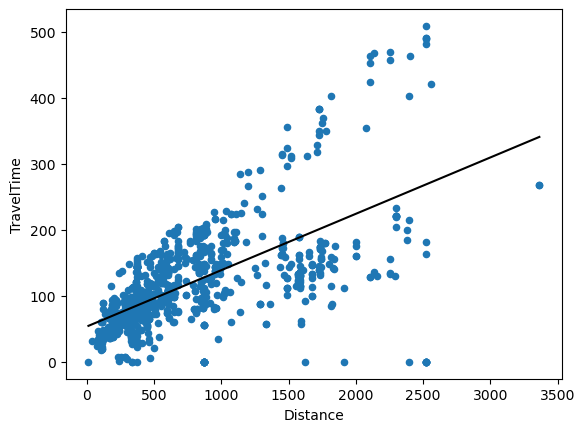

In [12]:
# Task 6: Impute missing travel times by the "Origin" and "Dest" columns and re-plot. 
data.impute(column = "Distance", by = ["Origin", "Dest"])
scatter_plot(data, "Distance", "TravelTime")

In [13]:
# Task 7: Create a test/train split
train,test = data.split_frame([.9])

In [14]:
# Task 8: Set response variable and your choice of predictor variables
myY = "IsDepDelayed"
myX = ["Origin", "Dest", "Year", "UniqueCarrier", "DayOfWeek", "Month", "Distance", "FlightNum"]

In [15]:
# Task 9: Build simple GLM model

data_glm = H2OGeneralizedLinearEstimator(family="binomial", standardize=True)
data_glm.train(x               =myX,
               y               =myY,
               training_frame  =train,
               validation_frame=test)


glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1668209675911_4


GLM Model: summary
    family    link    regularization                                number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  --------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    binomial  logit   Elastic Net (alpha = 0.5, lambda = 5.69E-5 )  309                           225                            3                       py_29_sid_8aa4

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.21130235519876286
RMSE: 0.45967635919064065
LogLoss: 0.6102284937592435
AUC: 0.7251799661740324
AUCPR: 0.741850940690574
Gini: 0.4503599323480647
Null degrees of freedom: 39539
Residual degrees of freedom: 39314
Null deviance: 54703.977451208426
Residual deviance: 48256.86928648097
AIC: 48708.86928648097

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37730277891974245
       NO    YES    Error    Rate
-----  ----  -----  -------  -----------------
NO     6902  11825  0.6314   (11825.0/18727.0)
YES    2702  18111  0.1298   (2702.0/20813.0)
Total  9604  29936  0.3674   (14527.0/39540.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.377303     0.713748  283
max f2                       0.145025     0.848228  385
max f0point5                 0.534745     0.689441  197
max accuracy                 0.50762      0.671067  210
max precision                0.983539     1         0
max recall                   0.080402     1         398
max specificity              0.983539     1         0
max absolute_mcc             0.534745     0.340576  197
max min_per_class_accuracy   0.526861     0.667612  201
max mean_per_class_accuracy  0.534745     0.670514  197
max tns                      0.983539     18727     0
max fns                      0.983539     20805     0
max fps                      0.0710071    18727     399
max tps                      0.080402     20813     398
max tnr                      0.983539     1         0
max fnr                      0.983539     0.999616  0
max fpr                      0.0710071    1         399
max tpr                      0.080402     1         398

Gains/Lift Table: Avg response rate: 52.64 %, avg score: 52.64 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100152                   0.91379            1.80862   1.80862            0.95202          0.945772  0.95202                     0.945772            0.0181137       0.0181137                  80.8623   80.8623            0.0170991
2        0.0200051                   0.888955           1.6593    1.73405            0.873418         0.900448  0.912769                    0.923139            0.0165762       0.0346899                  65.9296   73.4054            0.0310053
3        0.0300202                   0.869732           1.68389   1.71732            0.886364         0.878755  0.90396                     0.908332            0.0168645       0.0515543                  68.3891   71.7319            0.0454668
4        0.0400101                   0.853342           1.68815   1.71004            0.888608         0.861738  0.900126                    0.896698            0.0168645       0.0684188                

In [16]:
# Task 10: Build simple GBM model

data_gbm = H2OGradientBoostingEstimator(balance_classes=True,
                                        ntrees         =10,
                                        max_depth      =1,
                                        distribution   ="bernoulli",
                                        learn_rate     =0.1,
                                        min_rows       =2)

data_gbm.train(x               =myX,
               y               =myY,
               training_frame  =train,
               validation_frame=test)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1668209675911_7


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    10                 10                          868                    1            1            1             2             2             2

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.2356890690242745
RMSE: 0.4854781859407017
LogLoss: 0.6642087599207596
Mean Per-Class Error: 0.4620449047910054
AUC: 0.6749409111704382
AUCPR: 0.6621373529985323
Gini: 0.3498818223408764

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45205174739781767
       NO    YES    Error    Rate
-----  ----  -----  -------  -----------------
NO     2431  18417  0.8834   (18417.0/20848.0)
YES    847   19966  0.0407   (847.0/20813.0)
Total  3278  38383  0.4624   (19264.0/41661.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.452052     0.674573  22
max f2                       0.434807     0.8331    23
max f0point5                 0.541492     0.639468  11
max accuracy                 0.525613     0.639519  13
max precision                0.623681     0.767768  0
max recall                   0.434807     1         23
max specificity              0.623681     0.94671   0
max absolute_mcc             0.525613     0.279037  13
max min_per_class_accuracy   0.525613     0.637534  13
max mean_per_class_accuracy  0.525613     0.639517  13
max tns                      0.623681     19737     0
max fns                      0.623681     17140     0
max fps                      0.434807     20848     23
max tps                      0.434807     20813     23
max tnr                      0.623681     0.94671   0
max fnr                      0.623681     0.823524  0
max fpr                      0.434807     1         23
max tpr                      0.434807     1         23

Gains/Lift Table: Avg response rate: 49.96 %, avg score: 52.60 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------  --------------------
1        0.114832                    0.623681           1.53683   1.53683            0.767768         0.623681  0.767768                    0.623681            0.176476        0.176476                   53.6826    53.6826            0.123186
2        0.201507                    0.605107           1.36808   1.46424            0.683467         0.605975  0.731507                    0.616065            0.11858         0.295056                   36.8084    46.4244            0.18694
3        0.315067                    0.565391           1.20752   1.37171            0.603255         0.582039  0.685281                    0.603801            0.137126        0.432182                   20.7525    37.1715            0.234033
4        0.433739                    0.541492           1.17858   1.31887            0.588794         0.543647  0.658882                    0.587343            0.139865        0.572046                   17.8579    31.8872            0.276382
5        0.532512                    0.524796           0.998165  1.25939            0.498663         0.526261  0.629164                    0.576013    

In [17]:
# Variable importances from each algorithm
# Calculate magnitude of normalized GLM coefficients
from six import iteritems
glm_varimp = data_glm.coef_norm()
for k,v in iteritems(glm_varimp):
    glm_varimp[k] = abs(glm_varimp[k])
    
# Sort in descending order by magnitude
glm_sorted = sorted(glm_varimp.items(), key = operator.itemgetter(1), reverse = True)
table = tabulate(glm_sorted, headers = ["Predictor", "Normalized Coefficient"], tablefmt = "orgtbl")
print("Variable Importances:\n\n" + table)

data_glm.varimp()
data_gbm.varimp()

Variable Importances:

| Predictor        |   Normalized Coefficient |
|------------------+--------------------------|
| Year.2008        |              2.44525     |
| Origin.HPN       |              1.66307     |
| Year.2007        |              1.64904     |
| Dest.HTS         |              1.57848     |
| Origin.MDW       |              1.49392     |
| Year.2003        |              1.42418     |
| Origin.LIH       |              1.36609     |
| Dest.LYH         |              1.352       |
| UniqueCarrier.HP |              1.1538      |
| Origin.TLH       |              1.12918     |
| Origin.HNL       |              1.12528     |
| Origin.LEX       |              1.11798     |
| Origin.CAE       |              1.08863     |
| Year.1994        |              0.997503    |
| Origin.MYR       |              0.950903    |
| Origin.ERI       |              0.936859    |
| UniqueCarrier.TW |              0.93484     |
| Origin.LBB       |              0.925381    |
| Origin.CHO     

[('Year', 2788.8134765625, 1.0, 0.8425481746183596),
 ('Origin', 521.16162109375, 0.1868757539626262, 0.1574518253816404),
 ('Month', 0.0, 0.0, 0.0),
 ('DayOfWeek', 0.0, 0.0, 0.0),
 ('UniqueCarrier', 0.0, 0.0, 0.0),
 ('FlightNum', 0.0, 0.0, 0.0),
 ('Dest', 0.0, 0.0, 0.0),
 ('Distance', 0.0, 0.0, 0.0)]

In [18]:
dir(data_glm)

['F0point5',
 'F1',
 'F2',
 'HGLM',
 'Lambda',
 '_H2OEstimator__default_params',
 '_ModelBase__generate_partial_plots',
 '_ModelBase__generate_user_splits',
 '_ModelBase__grab_values',
 '_ModelBase__plot_1d_pdp',
 '_ModelBase__plot_1d_pdp_multinomial',
 '_ModelBase__plot_2d_pdp',
 '_ModelBase__pred_for_3d',
 '_ModelBase__set_axs_1d',
 '_ModelBase__set_axs_1d_multinomial',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_allowed_metrics',
 '_allowed_metrics_',
 '_bc',
 '_bci',
 '_check_and_save_parm',
 '_check_targets',
 '_default_metric',
 '_default_metrics_',
 '_default_param_value',
 '_delegate_to_metrics',
 '_end_time',
 '_estimator_

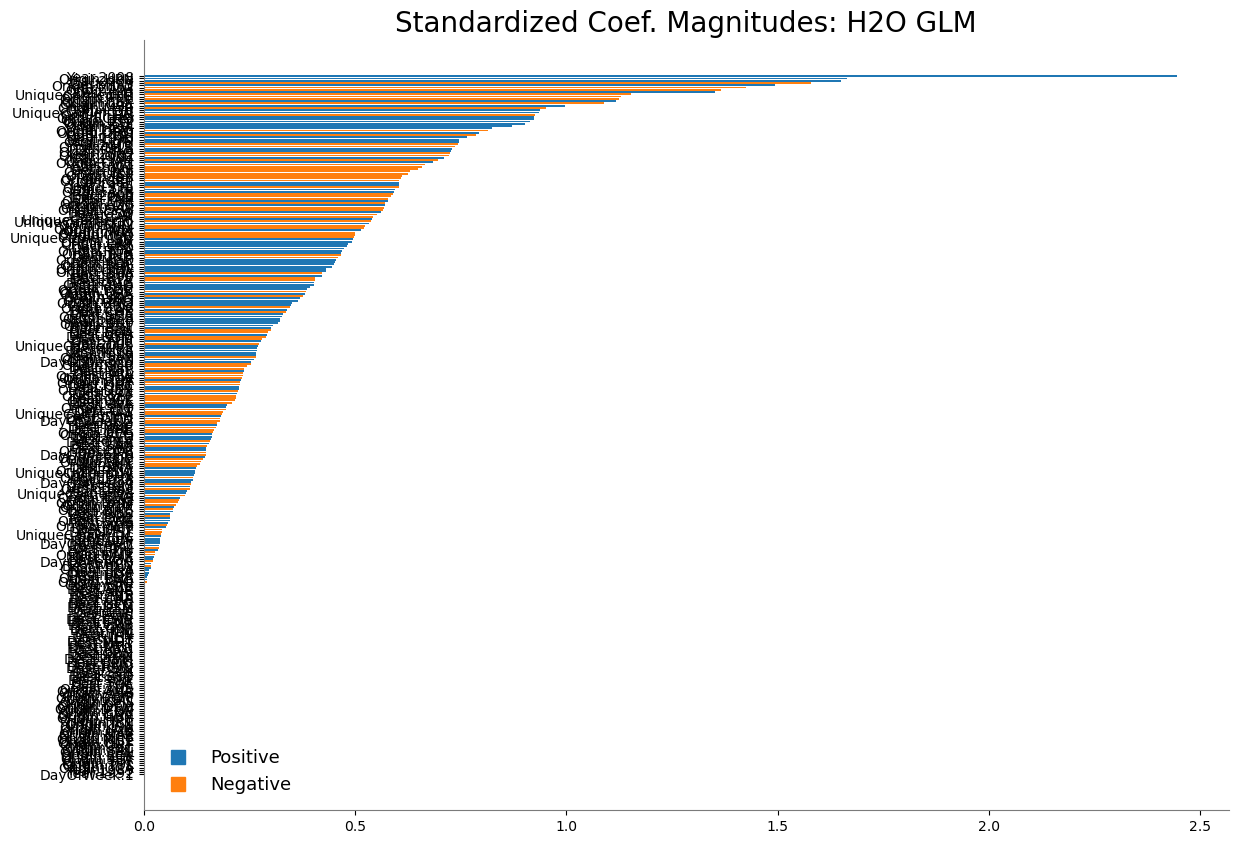

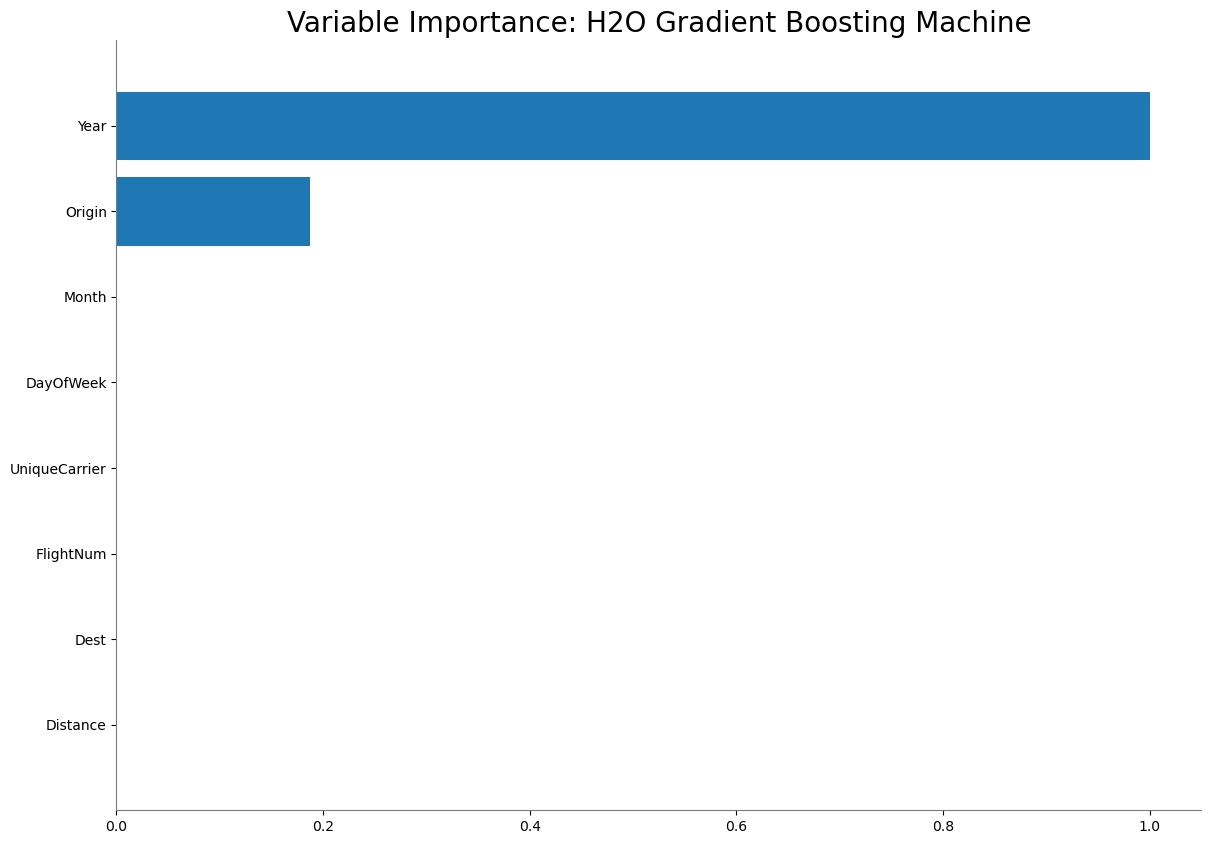

<Figure size 640x480 with 0 Axes>

In [19]:
data_glm.std_coef_plot()
data_gbm.varimp_plot()

In [20]:
# Model performance of GBM model on test data
data_gbm.model_performance(test)

ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.2340061659936069
RMSE: 0.483741838167433
LogLoss: 0.6607905659334226
Mean Per-Class Error: 0.41795922349039116
AUC: 0.6839414040906578
AUCPR: 0.685514119729272
Gini: 0.3678828081813157

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4687161838855877
       NO    YES    Error    Rate
-----  ----  -----  -------  ---------------
NO     600   1560   0.7222   (1560.0/2160.0)
YES    259   2019   0.1137   (259.0/2278.0)
Total  859   3579   0.4099   (1819.0/4438.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.468716     0.689431  21
max f2                       0.434807     0.84059   23
max f0point5                 0.508863     0.653044  15
max accuracy                 0.508863     0.645336  15
max precision                0.623681     0.809709  0
max recall                   0.434807     1         23
max specificity              0.623681     0.95463   0
max absolute_mcc             0.508863     0.289556  15
max min_per_class_accuracy   0.525613     0.63345   13
max mean_per_class_accuracy  0.508863     0.644186  15
max tns                      0.623681     2062      0
max fns                      0.623681     1861      0
max fps                      0.434807     2160      23
max tps                      0.434807     2278      23
max tnr                      0.623681     0.95463   0
max fnr                      0.623681     0.816945  0
max fpr                      0.434807     1         23
max tpr                      0.434807     1         23

Gains/Lift Table: Avg response rate: 51.33 %, avg score: 52.62 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.116043                    0.623681           1.57747   1.57747            0.809709         0.623681  0.809709                    0.623681            0.183055        0.183055                   57.7475   57.7475            0.137685
2        0.203695                    0.605107           1.29713   1.45684            0.66581          0.606004  0.747788                    0.616074            0.113696        0.296752                   29.7131   45.684             0.191196
3        0.305994                    0.569964           1.15862   1.35714            0.594714         0.585097  0.696613                    0.605718            0.118525        0.415277                   15.8621   35.7141            0.224536
4        0.440063                    0.541492           1.20494   1.31077            0.618487         0.546283  0.672811                    0.587611            0.161545        0.576822                   20.4937   31.0771            0.280988
5        0.531546                    0.524796           1.01729   1.26026            0.522167         0.526154  0.646884                    0.577034            0.0930641       0.669886                   1.72868   26.026             0.284238
6        0.601172                    0.507346           0.825936  1.20996            0.423948         0.507684  0.621064                    0.569002            0.0575066       0.727392                   -17.4064  20.9958            0.259337
7        0.806444                    0.468716           0.774148  1.09903            0.397366         0.477066  0.564124                    0.5456              0.158911        0.886304                   -22.5852  9.90266            0.164082
8        0.925417                    0.452052 

In [21]:
def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x

In [22]:
X=get_independent_variables(train, myY) 
print(X)
print(myY)

['DayofMonth', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'FlightNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Distance', 'TaxiIn', 'TaxiOut', 'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'Year', 'Month', 'DayOfWeek', 'UniqueCarrier', 'TailNum', 'Origin', 'Dest', 'Cancelled', 'CancellationCode', 'IsArrDelayed', 'TravelTime']
IsDepDelayed


In [23]:
print(train.columns)

['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'IsArrDelayed', 'IsDepDelayed', 'TravelTime']


In [24]:
train.head()

Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,IsArrDelayed,IsDepDelayed,TravelTime
1987,10,14,3,741,730,912,849,PS,1451,NA,91,79,nan,23,11,SAN,SFO,447,nan,nan,0,NA,0,nan,nan,nan,nan,nan,YES,YES,90.4
1987,10,15,4,729,730,903,849,PS,1451,NA,94,79,nan,14,-1,SAN,SFO,447,nan,nan,0,NA,0,nan,nan,nan,nan,nan,YES,NO,90.4
1987,10,17,6,741,730,918,849,PS,1451,NA,97,79,nan,29,11,SAN,SFO,447,nan,nan,0,NA,0,nan,nan,nan,nan,nan,YES,YES,90.4
1987,10,18,7,729,730,847,849,PS,1451,NA,78,79,nan,-2,-1,SAN,SFO,447,nan,nan,0,NA,0,nan,nan,nan,nan,nan,NO,NO,90.4
1987,10,19,1,749,730,922,849,PS,1451,NA,93,79,nan,33,19,SAN,SFO,447,nan,nan,0,NA,0,nan,nan,nan,nan,nan,YES,YES,90.4
1987,10,21,3,728,730,848,849,PS,1451,NA,80,79,nan,-1,-2,SAN,SFO,447,nan,nan,0,NA,0,nan,nan,nan,nan,nan,NO,NO,90.4
1987,10,22,4,728,730,852,849,PS,1451,NA,84,79,nan,3,-2,SAN,SFO,447,nan,nan,0,NA,0,nan,nan,nan,nan,nan,YES,NO,90.4
1987,10,23,5,731,730,902,849,PS,1451,NA,91,79,nan,13,1,SAN,SFO,447,nan,nan,0,NA,0,nan,nan,nan,nan,nan,YES,YES,90.4
1987,10,24,6,744,730,908,849,PS,1451,NA,84,79,nan,19,14,SAN,SFO,447,nan,nan,0,NA,0,nan,nan,nan,nan,nan,YES,YES,90.4
1987,10,26,1,735,730,904,849,PS,1451,NA,89,79,nan,15,5,SAN,SFO,447,nan,nan,0,NA,0,nan,nan,nan,nan,nan,YES,YES,90.4


In [25]:
# Set up AutoML
run_time=333
aml = H2OAutoML(max_runtime_secs=run_time)

In [26]:
model_start_time = time.time()
  
aml.train(x=X,y=myY,training_frame=train) 

AutoML progress: |█
19:00:48.42: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_3_AutoML_1_20221111_190048


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    72                 72                          335642                 1            8            7.70833       2             248           219.819

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 2.5639923930676273e-06
RMSE: 0.001601247136786707
LogLoss: 0.0013452461106839516
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.993010546820582
       NO     YES    Error    Rate
-----  -----  -----  -------  -------------
NO     18727  0      0        (0.0/18727.0)
YES    0      20813  0        (0.0/20813.0)
Total  18727  20813  0        (0.0/39540.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.993011     1         204
max f2                       0.993011     1         204
max f0point5                 0.993011     1         204
max accuracy                 0.993011     1         204
max precision                0.999609     1         0
max recall                   0.993011     1         204
max specificity              0.999609     1         0
max absolute_mcc             0.993011     1         204
max min_per_class_accuracy   0.993011     1         204
max mean_per_class_accuracy  0.993011     1         204
max tns                      0.999609     18727     0
max fns                      0.999609     20753     0
max fps                      0.000506724  18727     399
max tps                      0.993011     20813     204
max tnr                      0.999609     1         0
max fnr                      0.999609     0.997117  0
max fpr                      0.000506724  1         399
max tpr                      0.993011     1         204

Gains/Lift Table: Avg response rate: 52.64 %, avg score: 52.64 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100152                   0.999594           1.89977   1.89977            1                0.999601     1                           0.999601            0.0190266       0.0190266                  89.9774   89.9774            0.0190266
2        0.0201821                   0.999583           1.89977   1.89977            1                0.999588     1                           0.999594            0.0193149       0.0383414                  89.9774   89.9774            0.0383414
3        0.0300202                   0.999574           1.89977   1.89977            1                0.999578     1                           0.999589            0.0186902       0.0570317                  89.9774   89.9774            0.0570317
4        0.0400354                   0.999564           1.89977   1.89977            1                0.999569     1                           0.999584            0.0190266       0.0760582                  89.9774   89.9774            0.0760582
5        0.05                        0.999554           1.89977   1.89977            1                0.999559     1                           0.999579            0.0189305       0.

In [27]:
execution_time = time.time() - model_start_time
print(execution_time)

410.936194896698


In [28]:
print(aml.leaderboard)

model_id                                                   auc      logloss    aucpr    mean_per_class_error         rmse          mse
GBM_3_AutoML_1_20221111_190048                               1  0.00104316         1                       0  0.00149737   2.24211e-06
StackedEnsemble_AllModels_1_AutoML_1_20221111_190048         1  0.000845633        1                       0  0.000846462  7.16498e-07
StackedEnsemble_BestOfFamily_1_AutoML_1_20221111_190048      1  0.000845601        1                       0  0.000846423  7.16433e-07
DRF_1_AutoML_1_20221111_190048                               1  0.0535344          1                       0  0.0778504    0.00606069
StackedEnsemble_BestOfFamily_2_AutoML_1_20221111_190048      1  0.00140546         1                       0  0.00210783   4.44296e-06
GBM_5_AutoML_1_20221111_190048                               1  0.0144022          1                       0  0.0160005    0.000256017
GBM_1_AutoML_1_20221111_190048                          

In [29]:
dir(aml)

['_H2OAutoML__frozen',
 '_H2OAutoML__input',
 '_H2OAutoML__validate_algo_parameters',
 '_H2OAutoML__validate_distribution',
 '_H2OAutoML__validate_frame',
 '_H2OAutoML__validate_modeling_plan',
 '_H2OAutoML__validate_monotone_constraints',
 '_H2OAutoML__validate_nfolds',
 '_H2OAutoML__validate_not_set',
 '_H2OAutoML__validate_preprocessing',
 '_H2OAutoML__validate_project_name',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_algo_parameters',
 '_build_resp',
 '_custom_distribution_func',
 '_event_log',
 '_fetch',
 '_huber_alpha',
 '_job',
 '_leader_id',
 '_leaderboard',
 '_poll_training_updates',
 '_quantile_alpha',
 '_state_json',
 '_training_info',
 '_tweedie_powe

In [30]:
best_model = h2o.get_model(aml.leaderboard[0,'model_id'])

In [31]:
best_model.algo

'gbm'

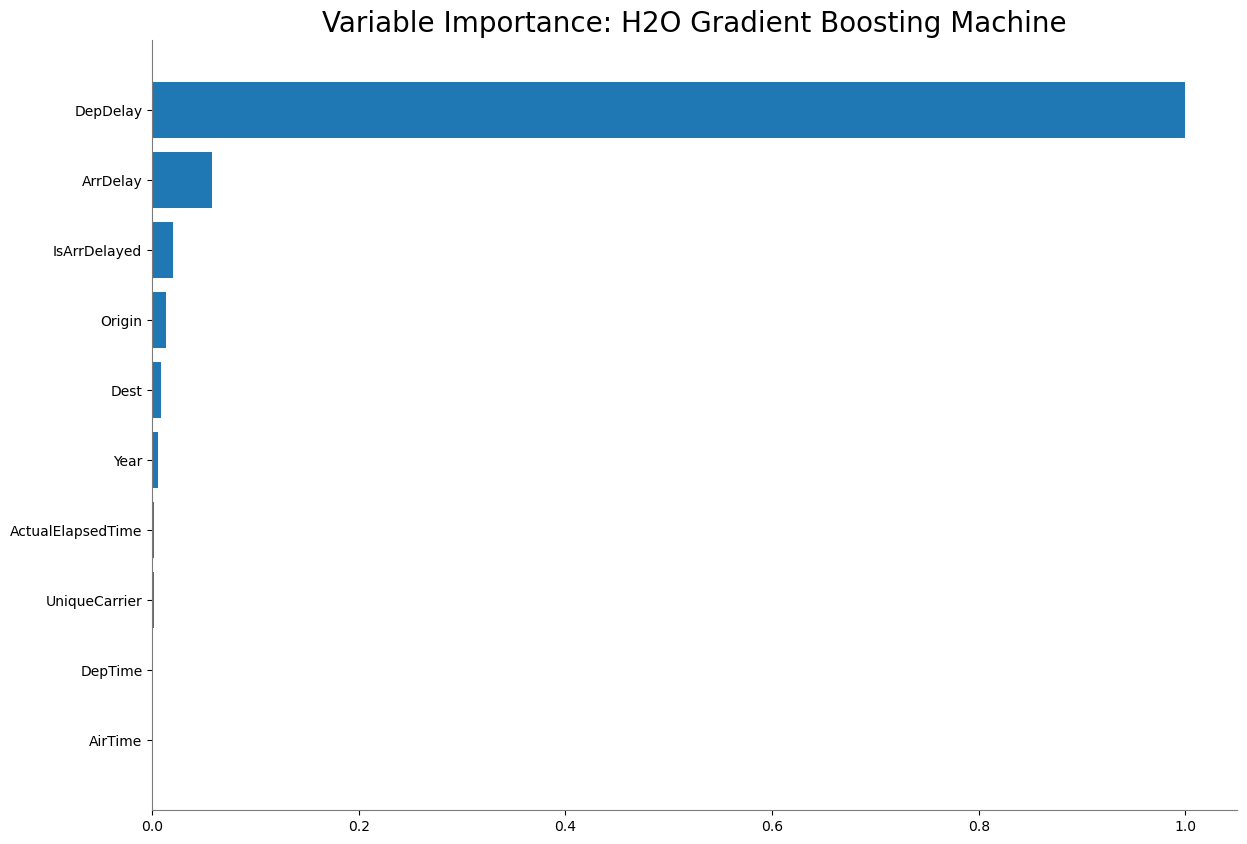

<Figure size 640x480 with 0 Axes>

In [32]:
if best_model.algo in ['xgboost','drf','gbm']:
  best_model.varimp_plot()

In [33]:
dir(best_model)

['F0point5',
 'F1',
 'F2',
 '_H2OEstimator__default_params',
 '_ModelBase__generate_partial_plots',
 '_ModelBase__generate_user_splits',
 '_ModelBase__grab_values',
 '_ModelBase__plot_1d_pdp',
 '_ModelBase__plot_1d_pdp_multinomial',
 '_ModelBase__plot_2d_pdp',
 '_ModelBase__pred_for_3d',
 '_ModelBase__set_axs_1d',
 '_ModelBase__set_axs_1d_multinomial',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_allowed_metrics',
 '_allowed_metrics_',
 '_bc',
 '_bci',
 '_calibrate',
 '_check_and_save_parm',
 '_check_targets',
 '_default_metric',
 '_default_metrics_',
 '_default_param_value',
 '_delegate_to_metrics',
 '_end_time',
 '_estimator_type'

In [34]:
best_model.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_3_AutoML_1_20221111_190048',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_3_AutoML_1_20221111_190048'},
  'input': None},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'AutoML_1_20221111_190048_training_py_29_sid_8aa4',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/AutoML_1_20221111_190048_training_py_29_sid_8aa4'},
  'input': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'AutoML_1_20221111_190048_training_py_29_sid_8aa4',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/AutoML_1_20221111_190048_training_py_29_sid_8aa4'}},
 'validation_frame': {'default': None, 'actual': None, 'input': None},
 'nfolds': {'default': 0, 'actual': 5, 'input': 5},
 'keep_c

In [35]:
best_model.confusion_matrix()

,NO,YES,Error,Rate
NO,18727.0,0.0,0.0,(0.0/18727.0)
YES,0.0,20813.0,0.0,(0.0/20813.0)
Total,18727.0,20813.0,0.0,(0.0/39540.0)


In [36]:
best_model.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])

[Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.993010546820582
       NO     YES    Error    Rate
-----  -----  -----  -------  -------------
NO     18727  0      0        (0.0/18727.0)
YES    0      20813  0        (0.0/20813.0)
Total  18727  20813  0        (0.0/39540.0),
 Confusion Matrix (Act/Pred) for max f2 @ threshold = 0.993010546820582
       NO     YES    Error    Rate
-----  -----  -----  -------  -------------
NO     18727  0      0        (0.0/18727.0)
YES    0      20813  0        (0.0/20813.0)
Total  18727  20813  0        (0.0/39540.0),
 Confusion Matrix (Act/Pred) for max f0point5 @ threshold = 0.993010546820582
       NO     YES    Error    Rate
-----  -----  -----  -------  -------------
NO     18727  0      0        (0.0/18727.0)
YES    0      20813  0        (0.0/20813.0)
Total  18727  20813  0        (0.0/39540.0),
 Confusion Matrix (Act/Pred) for max accuracy @ threshold = 0.993010546820582
       NO     YES    Error    Rate
-----  -----  -----  ------- 

In [37]:
h2o.cluster().shutdown()

H2O session _sid_8aa4 closed.
